#### Version history
* V1 - Basic training with default settings
* V2 - Added a custom evaluator to track the competition metric during training

## Training

All the heavy lifting here is done by the [detectron](https://github.com/facebookresearch/detectron2) library. What's needed from us is pointing it to the annotation files of our dataset (see [part one](https://www.kaggle.com/slawekbiel/positive-score-with-detectron-1-3-input-data/) for details), setting some hyperparameters and calling `trainer.train()`

Most of the code here is just for displaying things to make sure everything is set up correctly and the training worked.

In [1]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-ervzn7tz
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-ervzn7tz
  Resolved https://github.com/facebookresearch/detectron2.git to commit 72e9dd6e8513d3be1a242c2c75ea5529c71dd087
     |████████████████████████████████| 49 kB 1.1 MB/s 
     |████████████████████████████████| 74 kB 1.4 MB/s 
     |████████████████████████████████| 145 kB 3.5 MB/s 
     |████████████████████████████████| 130 kB 7.2 MB/s 
     |████████████████████████████████| 112 kB 7.2 MB/s 
  Created wheel for detectron2: filename=detectron2-0.6-cp37-cp37m-linux_x86_64.whl size=5727653 sha256=3e8774df7ee69eac0c0195d32f457b8f5e454b31137f5bc952f3eab90a3fa2ec
  Stored in directory: /tmp/pip-ephem-wheel-cache-7whwc2w2/wheels/07/dc/32/0322cb484dbefab8b9366bfedbaff5060ac7d149d69c27ca5d
  Created wheel for fvcore: filename=fvcore-0.1.5.post20211023-py3-none-any.whl size=60947 sha256=8e96f5223

In [2]:
import detectron2
from pathlib import Path
import random, cv2, os
import matplotlib.pyplot as plt
import numpy as np
import pycocotools.mask as mask_util
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.logger import setup_logger
from detectron2.evaluation.evaluator import DatasetEvaluator
setup_logger()

<_Logger detectron2 (DEBUG)>

### Load the competition data
This is very simple once we have our data in the COCO format. See the [part one notebook](https://www.kaggle.com/slawekbiel/positive-score-with-detectron-1-3-input-data/) for details.

In [3]:
dataDir=Path('../input/sartorius-cell-instance-segmentation/')
cfg = get_cfg()
cfg.INPUT.MASK_FORMAT='bitmask'
register_coco_instances('sartorius_train',{}, '../input/sartorius-cell-instance-segmentation-coco/annotations_train.json', dataDir)
register_coco_instances('sartorius_val',{},'../input/sartorius-cell-instance-segmentation-coco/annotations_val.json', dataDir)
metadata = MetadataCatalog.get('sartorius_train')
train_ds = DatasetCatalog.get('sartorius_train')

[10/27 19:40:57 d2.data.datasets.coco]: Loading ../input/sartorius-cell-instance-segmentation-coco/annotations_train.json takes 2.38 seconds.
[10/27 19:40:57 d2.data.datasets.coco]: Loaded 485 images in COCO format from ../input/sartorius-cell-instance-segmentation-coco/annotations_train.json


### Display a sample file to check the data is loaded correctly

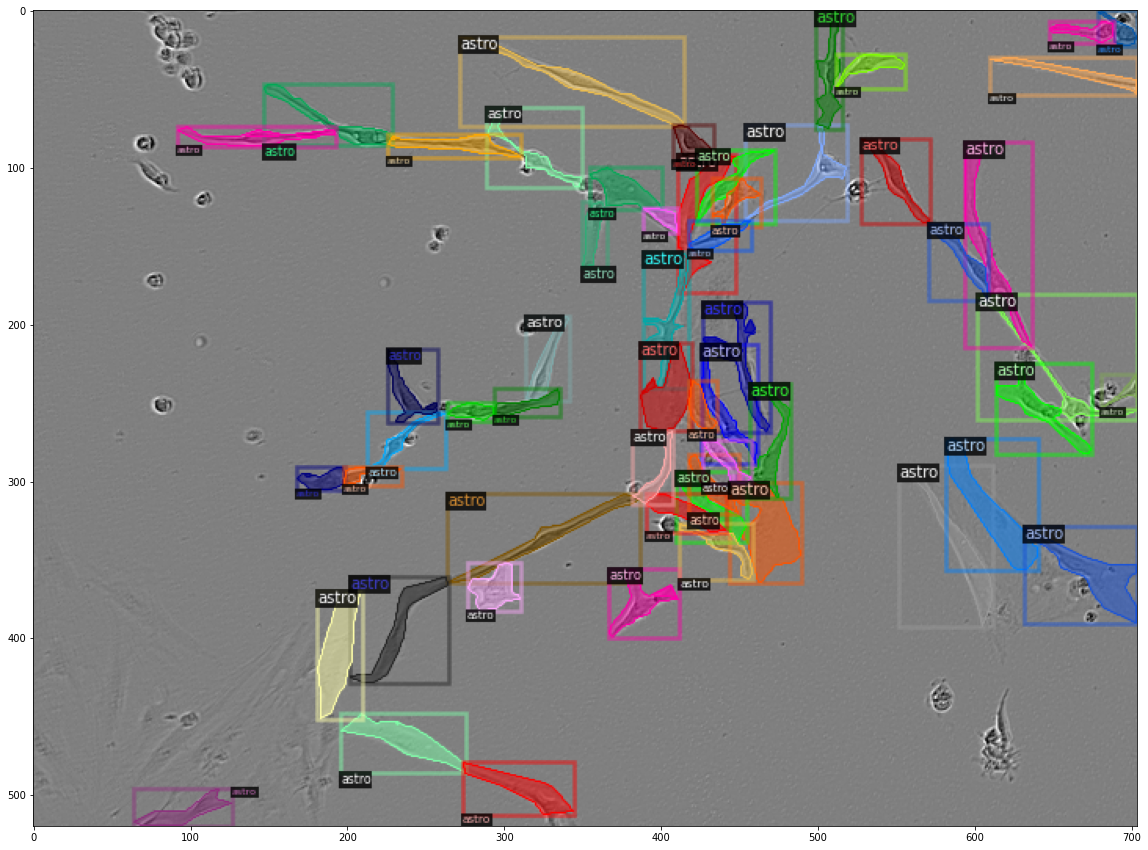

In [4]:
d = train_ds[42]
img = cv2.imread(d["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=metadata)
out = visualizer.draw_dataset_dict(d)
plt.figure(figsize = (20,15))
plt.imshow(out.get_image()[:, :, ::-1])

### Define evaluator 
Generates lines like this in the training output:
`[10/27 18:31:26 d2.evaluation.testing]: copypaste: MaP IoU=0.2192638391201311` 

See here for definition: https://www.kaggle.com/c/sartorius-cell-instance-segmentation/overview/evaluation

In [5]:
# Taken from https://www.kaggle.com/theoviel/competition-metric-map-iou
def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1  # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    return np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)

def score(pred, targ):
    pred_masks = pred['instances'].pred_masks.cpu().numpy()
    enc_preds = [mask_util.encode(np.asarray(p, order='F')) for p in pred_masks]
    enc_targs = list(map(lambda x:x['segmentation'], targ))
    ious = mask_util.iou(enc_preds, enc_targs, [0]*len(enc_targs))
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, ious)
        p = tp / (tp + fp + fn)
        prec.append(p)
    return np.mean(prec)

class MAPIOUEvaluator(DatasetEvaluator):
    def __init__(self, dataset_name):
        dataset_dicts = DatasetCatalog.get(dataset_name)
        self.annotations_cache = {item['image_id']:item['annotations'] for item in dataset_dicts}
            
    def reset(self):
        self.scores = []

    def process(self, inputs, outputs):
        for inp, out in zip(inputs, outputs):
            if len(out['instances']) == 0:
                self.scores.append(0)    
            else:
                targ = self.annotations_cache[inp['image_id']]
                self.scores.append(score(out, targ))

    def evaluate(self):
        return {"MaP IoU": np.mean(self.scores)}

class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return MAPIOUEvaluator(dataset_name)
    

### Train
I haven't done any hyperparameter optimization yet, this is mostly taken as is from the Detectron tutorial. 

Training for 1000 iterations here for demonstration. For a high scoring model you will need to train it longer, closer to 10000 with these settings

In [6]:
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("sartorius_train",)
cfg.DATASETS.TEST = ("sartorius_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0005 
cfg.SOLVER.MAX_ITER = 1000    
cfg.SOLVER.STEPS = []        
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = .5
cfg.TEST.EVAL_PERIOD = len(DatasetCatalog.get('sartorius_train')) // cfg.SOLVER.IMS_PER_BATCH  # Once per epoch

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = Trainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[10/27 19:41:02 d2.data.datasets.coco]: Loading ../input/sartorius-cell-instance-segmentation-coco/annotations_train.json takes 1.54 seconds.
[10/27 19:41:02 d2.data.datasets.coco]: Loaded 485 images in COCO format from ../input/sartorius-cell-instance-segmentation-coco/annotations_train.json
[10/27 19:41:08 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

model_final_f10217.pkl: 178MB [00:29, 6.13MB/s]                           


[10/27 19:41:47 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/opt/conda/lib/python3.7/site-packages/detectron2/data/detection_utils.py:433: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the res

[10/27 19:42:18 d2.utils.events]:  eta: 0:08:21  iter: 19  total_loss: 6.547  loss_cls: 1.417  loss_box_reg: 0.3723  loss_mask: 0.6928  loss_rpn_cls: 3.802  loss_rpn_loc: 0.3258  time: 1.2608  data_time: 0.8338  lr: 9.9905e-06  max_mem: 4060M
[10/27 19:42:57 d2.utils.events]:  eta: 0:10:52  iter: 39  total_loss: 3.087  loss_cls: 1.185  loss_box_reg: 0.3832  loss_mask: 0.6907  loss_rpn_cls: 0.517  loss_rpn_loc: 0.3258  time: 1.6112  data_time: 1.4703  lr: 1.998e-05  max_mem: 6777M
[10/27 19:43:37 d2.utils.events]:  eta: 0:10:38  iter: 59  total_loss: 2.832  loss_cls: 0.9731  loss_box_reg: 0.4452  loss_mask: 0.6852  loss_rpn_cls: 0.4064  loss_rpn_loc: 0.3079  time: 1.7452  data_time: 1.5455  lr: 2.997e-05  max_mem: 6777M
[10/27 19:44:09 d2.utils.events]:  eta: 0:11:11  iter: 79  total_loss: 2.588  loss_cls: 0.8287  loss_box_reg: 0.4989  loss_mask: 0.674  loss_rpn_cls: 0.3144  loss_rpn_loc: 0.2903  time: 1.7075  data_time: 1.1650  lr: 3.9961e-05  max_mem: 6777M
[10/27 19:44:39 d2.utils.ev

### Lets look at some of the validation files to check if things look reasonable
We show predictions on the left and ground truth on the right

[10/27 20:12:11 d2.data.datasets.coco]: Loaded 121 images in COCO format from ../input/sartorius-cell-instance-segmentation-coco/annotations_val.json


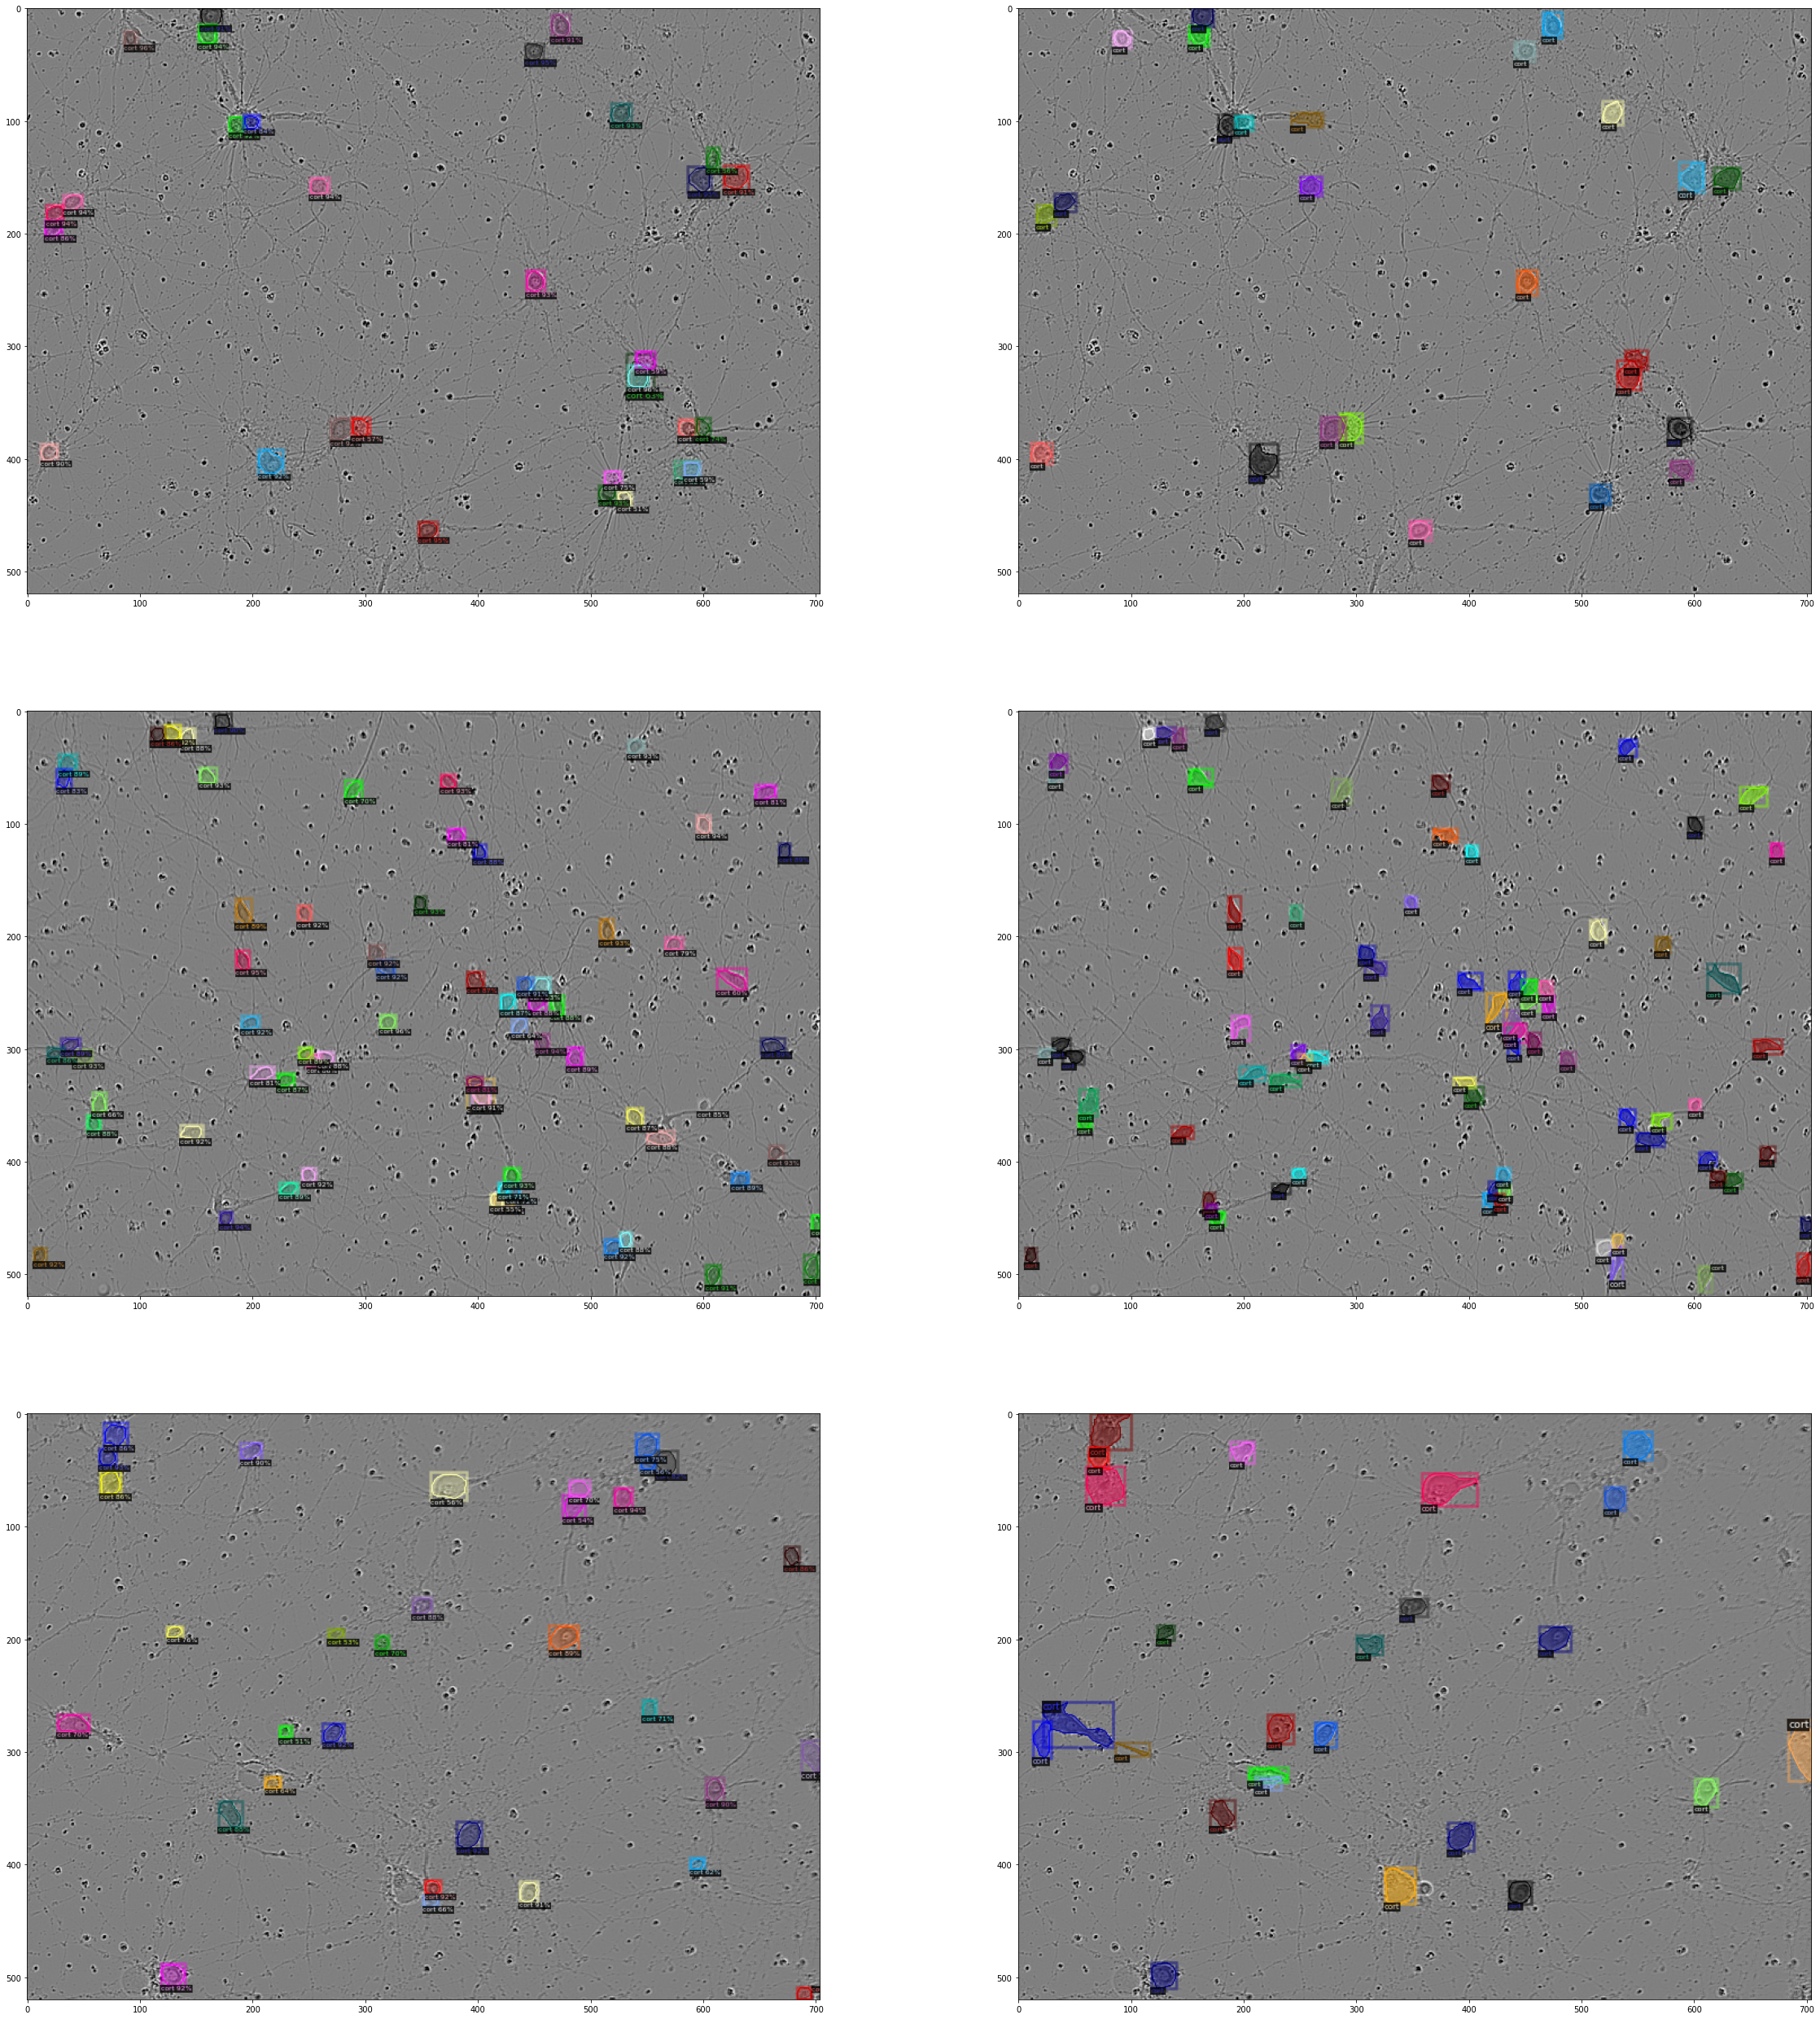

In [7]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)
dataset_dicts = DatasetCatalog.get('sartorius_val')
outs = []
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata = MetadataCatalog.get('sartorius_train'), 
                    
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out_pred = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    visualizer = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get('sartorius_train'))
    out_target = visualizer.draw_dataset_dict(d)
    outs.append(out_pred)
    outs.append(out_target)
_,axs = plt.subplots(len(outs)//2,2,figsize=(40,45))
for ax, out in zip(axs.reshape(-1), outs):
    ax.imshow(out.get_image()[:, :, ::-1])

### We can see that while it is not perfect, it did learn something
We can now take our model file and use it to generate submission in the [final notebook](https://www.kaggle.com/slawekbiel/positive-score-with-detectron-3-3-inference)

In [8]:
!ls ./output/model_final.pth

./output/model_final.pth
